In [1]:
# Set system error to null for keras backend message
import os
import sys
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.fashion_mnist import load_data

# Load FMNIST data from tensorflow data base
(x_train, y_train), (x_test, y_test) = load_data()

# Split the training data into validation data using 9:1 ratio
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)

# Preprocess the images
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_val = x_val.reshape(len(x_val), np.prod(x_val.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))


In [ ]:
# Build the model 
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers, Input
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

input_img = Input(shape=(784,))
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)

decoded = Dense(200, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

# encoder = Model(input_img, encoded)

# encoder_input = Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]

# decoder = Model(encoder_input, decoder_layer(encoder_input))

sgd = SGD(lr=0.001, momentum=0.5)
autoencoder.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
autoencoder.fit(x_train, x_train, epochs=20, batch_size=300, validation_data=(x_val, x_val), callbacks=[es])


In [ ]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
# Build the model 
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers, Input
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

input_img = Input(shape=(784,))
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
# encode1 = encoder(autoencoder.inputs)
h = Dropout(0.2)(encoded)
d = Dense(128, activation='relu')(h)
d = Dropout(0.4)(d)
d = Dense(100, activation='relu')(d)
d = Dropout(0.5)(d)
y = Dense(10, activation='sigmoid')(h)
sgd = SGD(lr=0.001, momentum=0.9, decay=2e-06)

mlp = Model(inputs=input_img, outputs=y)

mlp.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

esm = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

mlp.fit(x_train, y_train, batch_size=200, epochs=50, validation_data=(x_val, y_val), callbacks=[esm])


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 53us/step - loss: 2.0631 - accuracy: 0.1921 - val_loss: 1.8376 - val_accuracy: 0.2935
Epoch 2/50
54000/54000 [==============================] - 3s 52us/step - loss: 1.7697 - accuracy: 0.3357 - val_loss: 1.4870 - val_accuracy: 0.5397
Epoch 3/50
54000/54000 [==============================] - 3s 50us/step - loss: 1.4716 - accuracy: 0.4777 - val_loss: 1.0866 - val_accuracy: 0.6720
Epoch 4/50
54000/54000 [==============================] - 3s 48us/step - loss: 1.2286 - accuracy: 0.5388 - val_loss: 0.8924 - val_accuracy: 0.7003
Epoch 5/50
54000/54000 [==============================] - 3s 58us/step - loss: 1.0954 - accuracy: 0.5815 - val_loss: 0.7999 - val_accuracy: 0.7353
Epoch 6/50
54000/54000 [==============================] - 3s 53us/step - loss: 1.0148 - accuracy: 0.6230 - val_loss: 0.7396 - val_accuracy: 0.7542
Epoch 7/50
54000/54000 [==============================] - 3s 49us/ste

In [5]:
from sklearn.metrics import confusion_matrix

# Evalated the model with testing set
score = mlp.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy', score[1])

10000/10000 [==============================] - 1s 71us/step
Test loss: 0.4140357745409012
Test accuracy 0.8564000129699707


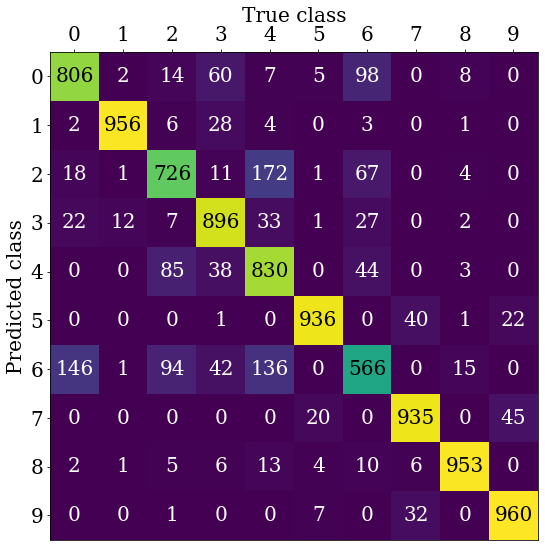

In [8]:
pred = mlp.predict(x_test)
y_classes = pred.argmax(axis=-1)

# Generate confusion matrix and plot it
conf = confusion_matrix(y_test, y_classes)
# conf_tosave = 'cnn_conf.pdf'
plot_conf(conf)


In [7]:
def plot_conf(conf, tosave=None):
# Plot the confusion matrix

    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.rc('font', size=20, family='serif')
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(conf)
    color_threshold = conf.max() / 2.
    for x in range(conf.shape[1]):
        for y in range(conf.shape[0]):
            val = conf[y, x]
            color = 'w' if val < color_threshold else 'k'
            ax.text(x, y, '%d'%val, ha='center', va='center', color=color, fontsize=20)
    ax.set_xticks(np.arange(conf.shape[1]))
    ax.set_yticks(np.arange(conf.shape[0]))
    ax.set_xticklabels(np.arange(conf.shape[1]))
    ax.set_yticklabels(np.arange(conf.shape[0]))
    ax.set_xlabel('True class')
    ax.set_ylabel('Predicted class')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_aspect('equal')
    fig.tight_layout()
    if type(tosave)!=type(None): fig.savefig(tosave); print('Saved: %s'%tosave)
    plt.show()